In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## 1. Imports and Model Loading

In [2]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd()) 
sys.path.insert(0, parent_dir)

from utils import (
    setup_sam_3d_body, setup_visualizer, 
    visualize_2d_results, visualize_3d_mesh, save_mesh_results, 
    display_results_grid, process_image_with_mask
)

# Set up SAM 3D Body estimator
estimator = setup_sam_3d_body(hf_repo_id="facebook/sam-3d-body-dinov3")
# Set up visualizer
visualizer = setup_visualizer()

/home/haonan/Projects/sam-3d-body/sam_3d_body/models/heads/mhr_head.py:33: UserWarning: Momentum is not enabled
  warnings.warn("Momentum is not enabled")


Loading SAM 3D Body model from facebook/sam-3d-body-dinov3...


/home/haonan/miniconda3/envs/sam_3d_body/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:56<00:00, 11.28s/it]


Loading SAM 3D Body model...


Using cache found in /home/haonan/.cache/torch/hub/facebookresearch_dinov3_main
Ignored kwargs: {'drop_path': 0.1}
The model and loaded state dict do not match exactly

missing keys in source state_dict: backbone.encoder.mask_token, head_pose.hand_pose_comps_ori, head_pose.mhr.face_expressions_model.shape_vectors, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_indices, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.0.sparse_weight, head_pose.mhr.pose_correctives_model.pose_dirs_predictor.2.weight, head_pose.mhr.character_torch.skeleton.joint_translation_offsets, head_pose.mhr.character_torch.skeleton.joint_prerotations, head_pose.mhr.character_torch.skeleton.pmi, head_pose.mhr.character_torch.skeleton.joint_parents, head_pose.mhr.character_torch.mesh.rest_vertices, head_pose.mhr.character_torch.mesh.faces, head_pose.mhr.character_torch.mesh.texcoords, head_pose.mhr.character_torch.mesh.texcoord_faces, head_pose.mhr.character_torch.parameter_transform.parame

Loading human detector from vitdet...
########### Using human detector: ViTDet...


/home/haonan/miniconda3/envs/sam_3d_body/lib/python3.11/site-packages/detectron2/config/lazy.py:167: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return old_import(name, globals, locals, fromlist=fromlist, level=level)
/home/haonan/miniconda3/envs/sam_3d_body/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading FOV estimator from moge2...
########### Using fov estimator: MoGe2...
Mask-condition inference is not supported...
Setup complete!
  Human detector: ✓
  Human segmentor: ✗ (mask inference disabled)
  FOV estimator: ✓


## 2. Process Image and Get Outputs

Processing image with SAM 3D Body...
Running object detector...
Found boxes: [[ 59.2648  139.26747 827.74866 569.5857 ]]
Running FOV estimator ...
Number of people detected: 1
Output keys for first person: ['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots', 'lhand_bbox', 'rhand_bbox']


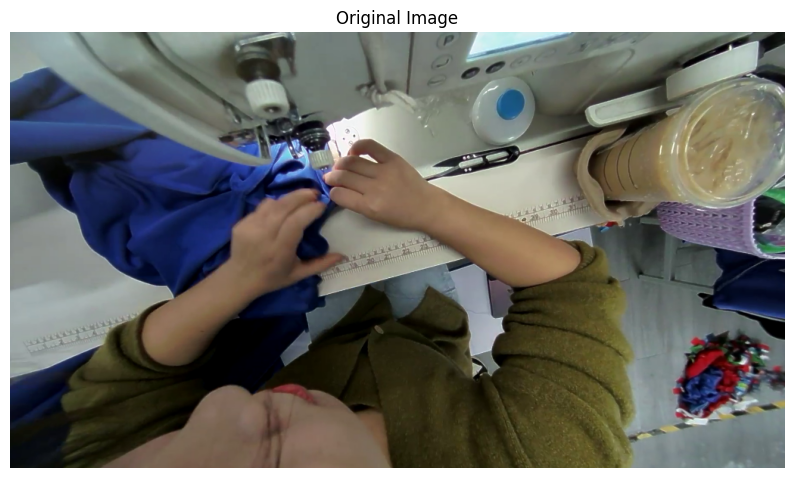

In [26]:
import cv2
import matplotlib.pyplot as plt

# Load and process the image
image_path = "images/factory_0003.png"  # Relative to notebook folder
img_cv2 = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Process the image with SAM 3D Body
print("Processing image with SAM 3D Body...")
outputs = estimator.process_one_image(image_path)

print(f"Number of people detected: {len(outputs)}")
print(f"Output keys for first person: {list(outputs[0].keys()) if outputs else 'No people detected'}")

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Original Image')
plt.show()

## 3. 2D Visualization - Keypoints and Bounding Boxes

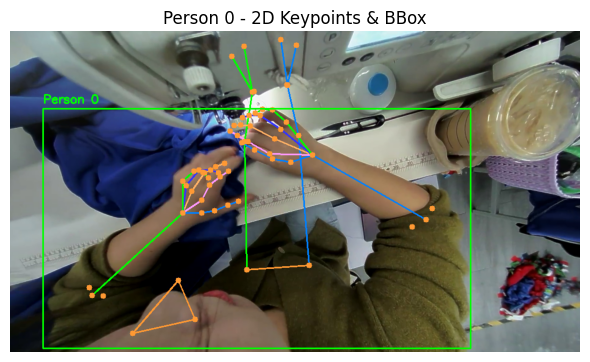

In [27]:
# Visualize 2D results using utils
if outputs:
    vis_results = visualize_2d_results(img_cv2, outputs, visualizer)
    
    # Display results using grid function
    titles = [f'Person {i} - 2D Keypoints & BBox' for i in range(len(vis_results))]
    display_results_grid(vis_results, titles, figsize_per_image=(6, 6))
else:
    print("No people detected in the image")

## 4. 3D Mesh Visualization - Overlay and Side View

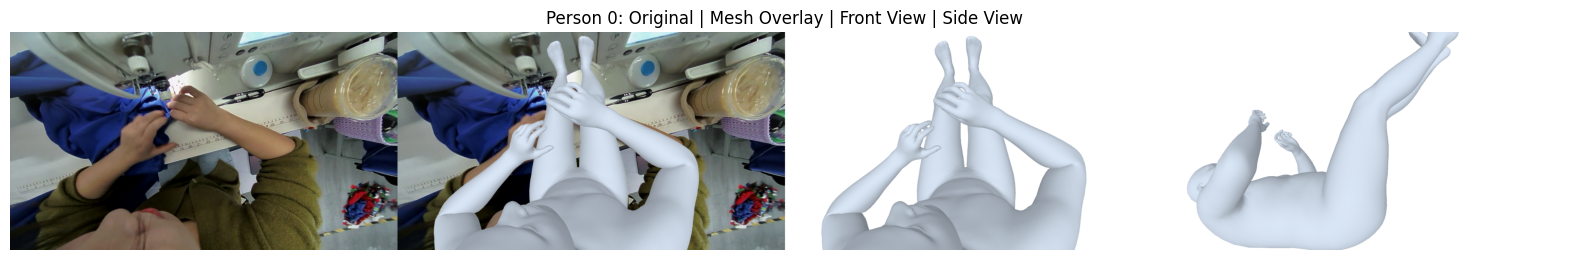

In [28]:
if outputs:
    mesh_results = visualize_3d_mesh(img_cv2, outputs, estimator.faces)
    
    # Display results
    for i, combined_img in enumerate(mesh_results):
        combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(20, 5))
        plt.imshow(combined_rgb)
        plt.title(f'Person {i}: Original | Mesh Overlay | Front View | Side View')
        plt.axis('off')
        plt.show()
else:
    print("No people detected for 3D mesh visualization")

## 5. Save 3D Mesh Files and Results

In [25]:
if outputs:
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Create output directory
    output_dir = f"output/{image_name}"

    # Save all results (PLY meshes, overlay images, bbox images)
    ply_files = save_mesh_results(img_cv2, outputs, estimator.faces, output_dir, image_name)
    
    print(f"\n=== Saved Results for {image_name} ===")
    print(f"Output directory: {output_dir}")
    print(f"Number of PLY files created: {len(ply_files)}")
    
else:
    print("No results to save - no people detected")

Saved focal length: output/factory_0002/factory_0002_focal_length.json
Saved mesh: output/factory_0002/factory_0002_mesh_000.ply
Saved overlay: output/factory_0002/factory_0002_overlay_000.png
Saved bbox: output/factory_0002/factory_0002_bbox_000.png

=== Saved Results for factory_0002 ===
Output directory: output/factory_0002
Number of PLY files created: 1


## 6. Mask-Based Inference

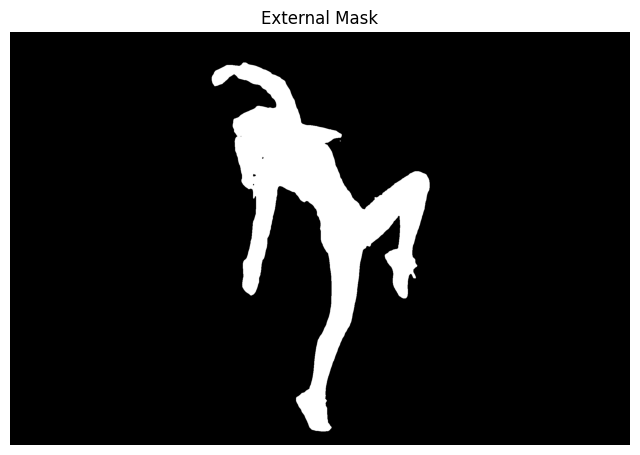

Processing image with external mask: images/dancing_mask.png
Mask shape: (1500, 2250), unique values: [  0 255]
Computed bbox from mask: [ 732.  114. 1523. 1451.]
Using provided masks: (1500, 2250)


ValueError: cannot reshape array of size 3375000 into shape (576,1024,1)

In [20]:
# Load mask and run inference
mask_path = "images/dancing_mask.png"

if os.path.exists(mask_path):
    # Load and display the mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(8, 6))
    plt.imshow(mask_img, cmap='gray')
    plt.title('External Mask')
    plt.axis('off')
    plt.show()
    
    # Process with external mask
    mask_outputs = process_image_with_mask(estimator, image_path, mask_path)
    
    # Visualize and save results
    if mask_outputs:
        mask_mesh_results = visualize_3d_mesh(img_cv2, mask_outputs, estimator.faces)
        
        for i, combined_img in enumerate(mask_mesh_results):
            combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(20, 5))
            plt.imshow(combined_rgb)
            plt.title(f'Mask-Based Person {i}: Original | Mesh Overlay | Front View | Side View')
            plt.axis('off')
            plt.show()
            
        # Save results
        mask_output_dir = f"output/mask_based_{image_name}"
        mask_ply_files = save_mesh_results(img_cv2, mask_outputs, estimator.faces, mask_output_dir, f"mask_{image_name}")
        print(f"Saved mask-based results to: {mask_output_dir}")
    else:
        print("No people detected with mask-based approach")
        
else:
    print(f"Mask file not found: {mask_path}")